# Fine_tune_SegFormer_on_custom_dataset con AUMENTACIÓN DE DATOS

In [26]:
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import numpy as np
from transformers import SegformerImageProcessor

1. Cargamos DATOS

In [27]:
import os
from datasets import Dataset


base_path = "/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles"

image_paths = []
mask_paths = []

for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if os.path.isdir(folder_path):
        images_dir = os.path.join(folder_path, "images")
        masks_dir = os.path.join(folder_path, "masks")
        
        if os.path.exists(images_dir) and os.path.exists(masks_dir):

            images = sorted(os.listdir(images_dir))
            masks = sorted(os.listdir(masks_dir))
            
            for img_name in images:
           
                img_base = os.path.splitext(img_name)[0]       
                mask_name = img_base + "_1.jpg"
                
                if mask_name in masks:
                    image_paths.append(os.path.join(images_dir, img_name))
                    mask_paths.append(os.path.join(masks_dir, mask_name))
                else:
                    print(f"Advertencia: máscara no encontrada para {img_name} en {masks_dir}")


data_dict = {
    "image": image_paths,
    "mask": mask_paths,
}


dataset = Dataset.from_dict(data_dict)

print(f"Dataset creado con {len(dataset)} pares imagen-máscara") 

Dataset creado con 322 pares imagen-máscara


In [28]:
import torch

if torch.cuda.is_available():
    print("✅ GPU disponible:", torch.cuda.get_device_name(0))
else:
    print("❌ No hay GPU disponible.")



✅ GPU disponible: NVIDIA GeForce RTX 3060


2. Cargamos clase

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
import cv2
import numpy as np
import albumentations as A

class CancerSegmentationDataset(Dataset):
    def __init__(self, base_path, image_processor, train=True, train_ratio=0.8, image_size=256):
        self.base_path = base_path
        self.image_processor = image_processor
        self.train = train
        self.image_size = image_size
        self.image_paths = []
        self.mask_paths = []

        for folder_name in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder_name)
            if os.path.isdir(folder_path):
                images_dir = os.path.join(folder_path, "images")
                masks_dir = os.path.join(folder_path, "masks")
                if os.path.exists(images_dir) and os.path.exists(masks_dir):
                    images = sorted(os.listdir(images_dir))
                    masks = sorted(os.listdir(masks_dir))
                    for img_name in images:
                        img_base = os.path.splitext(img_name)[0]
                        mask_name = img_base + "_1.jpg"
                        if mask_name in masks:
                            self.image_paths.append(os.path.join(images_dir, img_name))
                            self.mask_paths.append(os.path.join(masks_dir, mask_name))

        split_index = int(train_ratio * len(self.image_paths))
        if train:
            self.image_paths = self.image_paths[:split_index]
            self.mask_paths = self.mask_paths[:split_index]
        else:
            self.image_paths = self.image_paths[split_index:]
            self.mask_paths = self.mask_paths[split_index:]

        # ⚙️ Aumentación intensificada para entrenamiento
        if self.train:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomBrightnessContrast(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=20, p=0.5),
                A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.MotionBlur(blur_limit=3, p=0.2),
                A.GridDistortion(p=0.2),
                A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
                A.Resize(height=self.image_size, width=self.image_size)
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=self.image_size, width=self.image_size)
            ])

    def __len__(self):
        return len(self.image_paths)

    def load_mask(self, mask_path):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            mask = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        else:
            mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)
            mask = (mask > 0).astype(np.uint8)
        return mask

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = self.load_mask(self.mask_paths[idx])
        
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        augmented = self.transform(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask'].astype(np.int64)

        encoded = self.image_processor(images=image, segmentation_maps=mask, return_tensors="pt")
        for k, v in encoded.items():
            encoded[k] = v.squeeze(0)

        return encoded



In [30]:
from transformers import SegformerImageProcessor

root_dir = "/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles"
image_processor = SegformerImageProcessor(reduce_labels=False)

train_dataset = CancerSegmentationDataset(base_path=root_dir,
                                          image_processor=image_processor,
                                          train=True,
                                          image_size=512)

valid_dataset = CancerSegmentationDataset(base_path=root_dir,
                                          image_processor=image_processor,
                                          train=False,
                                          image_size=512)


/home/anna/.venvs/venv_finetune/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_2157267/1755070196.py:47: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/tmp/ipykernel_2157267/1755070196.py:48: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


In [31]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 257
Number of validation examples: 65


In [32]:
encoded_inputs = train_dataset[0]

In [33]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [34]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [35]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [36]:
encoded_inputs["labels"].squeeze().unique()

tensor([0, 1])

3. DataLoader

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

In [38]:
batch = next(iter(train_dataloader))

In [39]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


In [40]:
batch["labels"].shape

torch.Size([4, 512, 512])

In [41]:
mask = (batch["labels"] != 0)
mask

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [42]:
batch["labels"][mask]

tensor([1, 1, 1,  ..., 1, 1, 1])

4. Modelo

In [43]:
id2label = {
    0: "background",
    1: "tumor"
}
label2id = {v: k for k, v in id2label.items()}


In [44]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/mit-b0",  #binario
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
image_processor.do_reduce_labels

False

In [ ]:
import torch
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import time 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=1e-2)

best_val_dice = 0.0
history = {
    "train_loss": [],
    "train_dice": [],
    "val_dice": [],
}

def compute_dice(preds, targets, smooth=1e-6):
    preds = preds.flatten()
    targets = targets.flatten()
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

total_start_time = time.time() 


for epoch in range(50):
    print(f"\n🔁 Epoch {epoch+1}/50")
    epoch_start_time = time.time() 
    model.train()

    train_loss = 0.0
    dice_scores = []

    for batch in tqdm(train_dataloader, desc="Entrenamiento"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)

            mask = labels != 255
            dice = compute_dice(predicted[mask], labels[mask])
            dice_scores.append(dice)

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_dice = sum(dice_scores) / len(dice_scores)

    history["train_loss"].append(avg_train_loss)
    history["train_dice"].append(avg_train_dice)

    print(f"📊 Train Loss: {avg_train_loss:.4f} | Dice: {avg_train_dice:.4f}")


    model.eval()
    val_dice_scores = []

    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc="Validación"):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits

            upsampled_logits = nn.functional.interpolate(
                logits, size=labels.shape[-2:], mode="bilinear", align_corners=False
            )
            predicted = upsampled_logits.argmax(dim=1)

            mask = labels != 255
            dice = compute_dice(predicted[mask], labels[mask])
            val_dice_scores.append(dice)

    avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)
    history["val_dice"].append(avg_val_dice)

    print(f"✅ Val Dice: {avg_val_dice:.4f}")

    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print(f"💾 Saved new best model with Dice: {best_val_dice:.4f}")

    epoch_duration = time.time() - epoch_start_time
    print(f"🕒 Duración de la época: {epoch_duration:.2f} segundos")

total_duration = time.time() - total_start_time
print(f"\n🏁 Entrenamiento completo en {total_duration / 60:.2f} minutos ({total_duration:.2f} segundos)")


🔁 Epoch 1/50


Entrenamiento:   0%|          | 0/65 [00:00<?, ?it/s]

Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s]


📊 Train Loss: 0.4943 | Dice: 0.4315


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.88it/s]


✅ Val Dice: 0.5083
💾 Saved new best model with Dice: 0.5083
🕒 Duración de la época: 13.62 segundos

🔁 Epoch 2/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.37it/s]


📊 Train Loss: 0.3063 | Dice: 0.5510


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.94it/s]


✅ Val Dice: 0.5296
💾 Saved new best model with Dice: 0.5296
🕒 Duración de la época: 13.28 segundos

🔁 Epoch 3/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s]


📊 Train Loss: 0.2410 | Dice: 0.5818


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.93it/s]


✅ Val Dice: 0.6227
💾 Saved new best model with Dice: 0.6227
🕒 Duración de la época: 13.34 segundos

🔁 Epoch 4/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.32it/s]


📊 Train Loss: 0.2060 | Dice: 0.5889


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.90it/s]


✅ Val Dice: 0.6596
💾 Saved new best model with Dice: 0.6596
🕒 Duración de la época: 13.38 segundos

🔁 Epoch 5/50


Entrenamiento: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


📊 Train Loss: 0.1812 | Dice: 0.6172


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.88it/s]


✅ Val Dice: 0.6537
🕒 Duración de la época: 14.33 segundos

🔁 Epoch 6/50


Entrenamiento: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


📊 Train Loss: 0.1622 | Dice: 0.6396


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.96it/s]


✅ Val Dice: 0.6671
💾 Saved new best model with Dice: 0.6671
🕒 Duración de la época: 14.34 segundos

🔁 Epoch 7/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


📊 Train Loss: 0.1512 | Dice: 0.6633


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.61it/s]


✅ Val Dice: 0.6473
🕒 Duración de la época: 13.91 segundos

🔁 Epoch 8/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]


📊 Train Loss: 0.1457 | Dice: 0.6554


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.32it/s]


✅ Val Dice: 0.6936
💾 Saved new best model with Dice: 0.6936
🕒 Duración de la época: 13.90 segundos

🔁 Epoch 9/50


Entrenamiento: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]


📊 Train Loss: 0.1384 | Dice: 0.6855


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.57it/s]


✅ Val Dice: 0.6874
🕒 Duración de la época: 14.24 segundos

🔁 Epoch 10/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


📊 Train Loss: 0.1266 | Dice: 0.7189


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.05it/s]


✅ Val Dice: 0.6646
🕒 Duración de la época: 13.55 segundos

🔁 Epoch 11/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.28it/s]


📊 Train Loss: 0.1287 | Dice: 0.7098


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.69it/s]


✅ Val Dice: 0.7049
💾 Saved new best model with Dice: 0.7049
🕒 Duración de la época: 13.49 segundos

🔁 Epoch 12/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


📊 Train Loss: 0.1194 | Dice: 0.7280


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.38it/s]


✅ Val Dice: 0.6981
🕒 Duración de la época: 13.62 segundos

🔁 Epoch 13/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.36it/s]


📊 Train Loss: 0.1157 | Dice: 0.7339


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.14it/s]


✅ Val Dice: 0.6984
🕒 Duración de la época: 13.24 segundos

🔁 Epoch 14/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]


📊 Train Loss: 0.1141 | Dice: 0.7396


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.77it/s]


✅ Val Dice: 0.6498
🕒 Duración de la época: 14.05 segundos

🔁 Epoch 15/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.28it/s]


📊 Train Loss: 0.1049 | Dice: 0.7566


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.86it/s]


✅ Val Dice: 0.7189
💾 Saved new best model with Dice: 0.7189
🕒 Duración de la época: 13.48 segundos

🔁 Epoch 16/50


Entrenamiento: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]


📊 Train Loss: 0.1158 | Dice: 0.7392


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.90it/s]


✅ Val Dice: 0.6842
🕒 Duración de la época: 14.14 segundos

🔁 Epoch 17/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]


📊 Train Loss: 0.1085 | Dice: 0.7508


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.29it/s]


✅ Val Dice: 0.7336
💾 Saved new best model with Dice: 0.7336
🕒 Duración de la época: 13.93 segundos

🔁 Epoch 18/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.26it/s]


📊 Train Loss: 0.1171 | Dice: 0.7224


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.11it/s]


✅ Val Dice: 0.7312
🕒 Duración de la época: 13.48 segundos

🔁 Epoch 19/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


📊 Train Loss: 0.1054 | Dice: 0.7574


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.39it/s]


✅ Val Dice: 0.6599
🕒 Duración de la época: 14.12 segundos

🔁 Epoch 20/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.1028 | Dice: 0.7626


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.07it/s]


✅ Val Dice: 0.7079
🕒 Duración de la época: 13.03 segundos

🔁 Epoch 21/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.02it/s]


📊 Train Loss: 0.1000 | Dice: 0.7686


Validación: 100%|██████████| 17/17 [00:01<00:00, 14.52it/s]


✅ Val Dice: 0.7109
🕒 Duración de la época: 14.12 segundos

🔁 Epoch 22/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


📊 Train Loss: 0.0945 | Dice: 0.7867


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.07it/s]


✅ Val Dice: 0.7115
🕒 Duración de la época: 13.56 segundos

🔁 Epoch 23/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.38it/s]


📊 Train Loss: 0.0970 | Dice: 0.7802


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.05it/s]


✅ Val Dice: 0.7066
🕒 Duración de la época: 13.15 segundos

🔁 Epoch 24/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]


📊 Train Loss: 0.0990 | Dice: 0.7620


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.02it/s]


✅ Val Dice: 0.7125
🕒 Duración de la época: 13.49 segundos

🔁 Epoch 25/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.53it/s]


📊 Train Loss: 0.0898 | Dice: 0.7908


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s]


✅ Val Dice: 0.7233
🕒 Duración de la época: 12.82 segundos

🔁 Epoch 26/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0954 | Dice: 0.7848


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s]


✅ Val Dice: 0.7295
🕒 Duración de la época: 13.00 segundos

🔁 Epoch 27/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.43it/s]


📊 Train Loss: 0.0889 | Dice: 0.7871


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.99it/s]


✅ Val Dice: 0.6954
🕒 Duración de la época: 13.04 segundos

🔁 Epoch 28/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.62it/s]


📊 Train Loss: 0.0870 | Dice: 0.8031


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s]


✅ Val Dice: 0.7394
💾 Saved new best model with Dice: 0.7394
🕒 Duración de la época: 12.65 segundos

🔁 Epoch 29/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.30it/s]


📊 Train Loss: 0.0862 | Dice: 0.8095


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.15it/s]


✅ Val Dice: 0.7370
🕒 Duración de la época: 13.33 segundos

🔁 Epoch 30/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s]


📊 Train Loss: 0.0799 | Dice: 0.8163


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s]


✅ Val Dice: 0.7285
🕒 Duración de la época: 12.79 segundos

🔁 Epoch 31/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.0948 | Dice: 0.7813


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.85it/s]


✅ Val Dice: 0.6923
🕒 Duración de la época: 12.98 segundos

🔁 Epoch 32/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.43it/s]


📊 Train Loss: 0.0807 | Dice: 0.8136


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.96it/s]


✅ Val Dice: 0.7190
🕒 Duración de la época: 13.05 segundos

🔁 Epoch 33/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.70it/s]


📊 Train Loss: 0.0833 | Dice: 0.8055


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.06it/s]


✅ Val Dice: 0.7296
🕒 Duración de la época: 12.47 segundos

🔁 Epoch 34/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.65it/s]


📊 Train Loss: 0.0848 | Dice: 0.8035


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.78it/s]


✅ Val Dice: 0.7338
🕒 Duración de la época: 12.58 segundos

🔁 Epoch 35/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.43it/s]


📊 Train Loss: 0.0821 | Dice: 0.8101


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s]


✅ Val Dice: 0.7445
💾 Saved new best model with Dice: 0.7445
🕒 Duración de la época: 13.05 segundos

🔁 Epoch 36/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.46it/s]


📊 Train Loss: 0.0865 | Dice: 0.8114


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s]


✅ Val Dice: 0.7363
🕒 Duración de la época: 12.95 segundos

🔁 Epoch 37/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.36it/s]


📊 Train Loss: 0.0807 | Dice: 0.8129


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.04it/s]


✅ Val Dice: 0.7405
🕒 Duración de la época: 13.19 segundos

🔁 Epoch 38/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s]


📊 Train Loss: 0.0790 | Dice: 0.8235


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.10it/s]


✅ Val Dice: 0.7405
🕒 Duración de la época: 13.21 segundos

🔁 Epoch 39/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.15it/s]


📊 Train Loss: 0.0818 | Dice: 0.8117


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s]


✅ Val Dice: 0.7423
🕒 Duración de la época: 13.68 segundos

🔁 Epoch 40/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0787 | Dice: 0.8129


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.88it/s]


✅ Val Dice: 0.7452
💾 Saved new best model with Dice: 0.7452
🕒 Duración de la época: 13.06 segundos

🔁 Epoch 41/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.40it/s]


📊 Train Loss: 0.0778 | Dice: 0.8148


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.06it/s]


✅ Val Dice: 0.7345
🕒 Duración de la época: 13.09 segundos

🔁 Epoch 42/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]


📊 Train Loss: 0.0774 | Dice: 0.8196


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.93it/s]


✅ Val Dice: 0.7514
💾 Saved new best model with Dice: 0.7514
🕒 Duración de la época: 13.86 segundos

🔁 Epoch 43/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s]


📊 Train Loss: 0.0829 | Dice: 0.8034


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.90it/s]


✅ Val Dice: 0.7355
🕒 Duración de la época: 13.03 segundos

🔁 Epoch 44/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.21it/s]


📊 Train Loss: 0.0779 | Dice: 0.8292


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.93it/s]


✅ Val Dice: 0.7380
🕒 Duración de la época: 13.54 segundos

🔁 Epoch 45/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.55it/s]


📊 Train Loss: 0.0776 | Dice: 0.8183


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s]


✅ Val Dice: 0.7501
🕒 Duración de la época: 12.75 segundos

🔁 Epoch 46/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.14it/s]


📊 Train Loss: 0.0785 | Dice: 0.8077


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.89it/s]


✅ Val Dice: 0.7438
🕒 Duración de la época: 13.71 segundos

🔁 Epoch 47/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.38it/s]


📊 Train Loss: 0.0744 | Dice: 0.8275


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.13it/s]


✅ Val Dice: 0.7335
🕒 Duración de la época: 13.14 segundos

🔁 Epoch 48/50


Entrenamiento: 100%|██████████| 65/65 [00:11<00:00,  5.70it/s]


📊 Train Loss: 0.0726 | Dice: 0.8355


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.01it/s]


✅ Val Dice: 0.7452
🕒 Duración de la época: 12.48 segundos

🔁 Epoch 49/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.41it/s]


📊 Train Loss: 0.0706 | Dice: 0.8279


Validación: 100%|██████████| 17/17 [00:01<00:00, 16.03it/s]


✅ Val Dice: 0.7458
🕒 Duración de la época: 13.08 segundos

🔁 Epoch 50/50


Entrenamiento: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s]


📊 Train Loss: 0.0737 | Dice: 0.8298


Validación: 100%|██████████| 17/17 [00:01<00:00, 15.74it/s]

✅ Val Dice: 0.7228
🕒 Duración de la época: 13.62 segundos

🏁 Entrenamiento completo en 11.15 minutos (668.96 segundos)


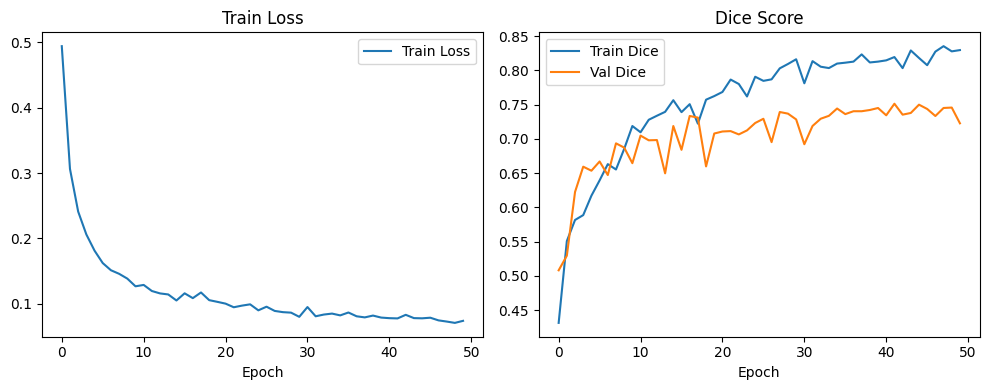

In [47]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_dice"], label="Train Dice")
plt.plot(history["val_dice"], label="Val Dice")
plt.title("Dice Score")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()

5. Inferencia

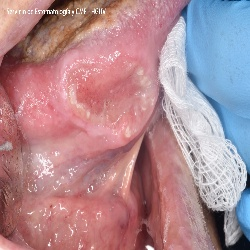

In [72]:
image_path = "/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles/00033C/images/00033C.jpg"
image = Image.open(image_path).convert("RGB")
image

In [61]:
image_size=512
pixel_values = image_processor(image, return_tensors="pt", size=(image_size, image_size)).pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [50]:
import torch

with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [51]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [52]:
def cancer_palette():
    """Paleta para segmentación binaria: fondo y tumor"""
    return [
        [0, 0, 0],       # 0: fondo - negro
        [255, 0, 0],     # 1: tumor - rojo brillante
    ]

In [53]:
from PIL import Image


predicted_segmentation_map = image_processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=[image.size[::-1]]  
)[0]


predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

print(predicted_segmentation_map.shape) 
print(predicted_segmentation_map)        


(250, 250)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


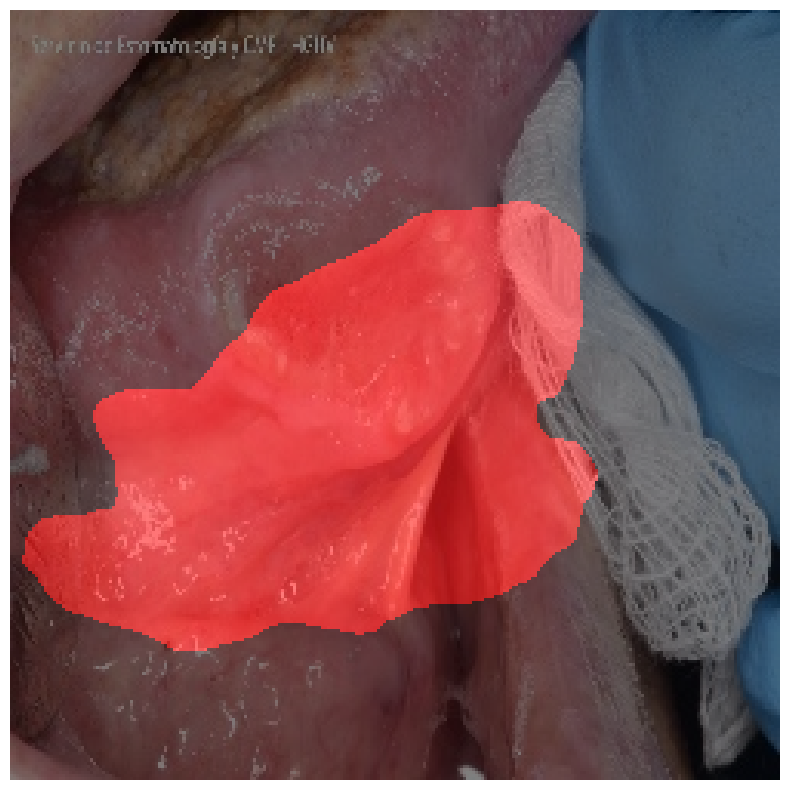

In [73]:
import matplotlib.pyplot as plt
import numpy as np


color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8)

palette = np.array(cancer_palette()) 

for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color

img_np = np.array(image)

blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()

In [55]:
mask_path = '/home/anna/TFM/FINETUNE/data/Organized_Cancer_Controles/00069C/masks/00069C_1.jpg'  
mask 

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')

Clases en esta imagen: ['background', 'tumor']


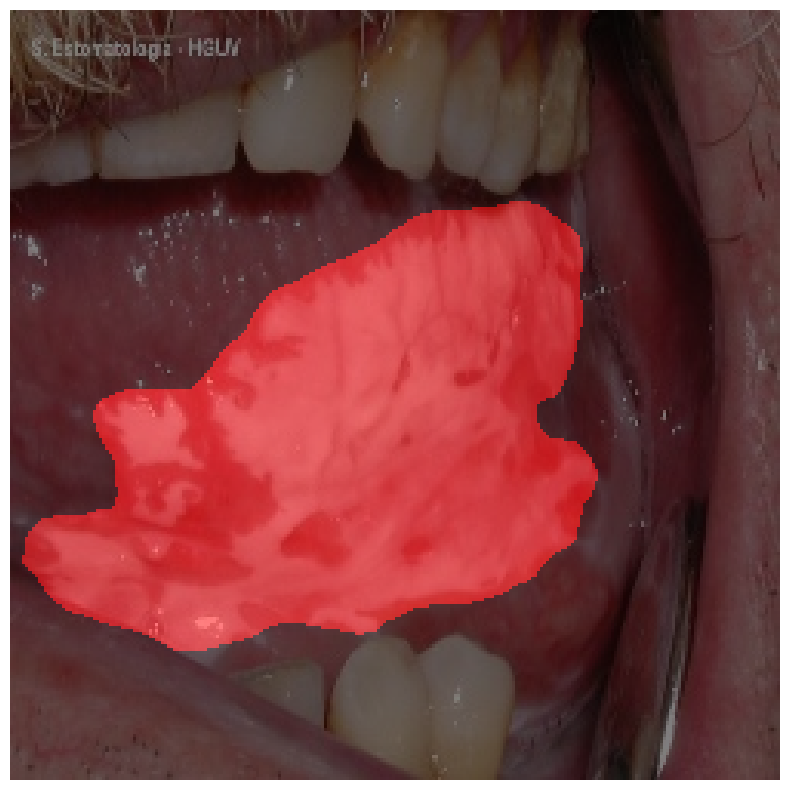

In [56]:
import numpy as np
import matplotlib.pyplot as plt


map = predicted_segmentation_map


classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx in model.config.id2label else None for idx in classes_map]
print("Clases en esta imagen:", unique_classes)

color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8)  
palette = np.array(cancer_palette())

for label, color in enumerate(palette):
    color_seg[map == label] = color


img_np = np.array(image)
blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()

Clases en esta imagen: ['background', 'tumor']


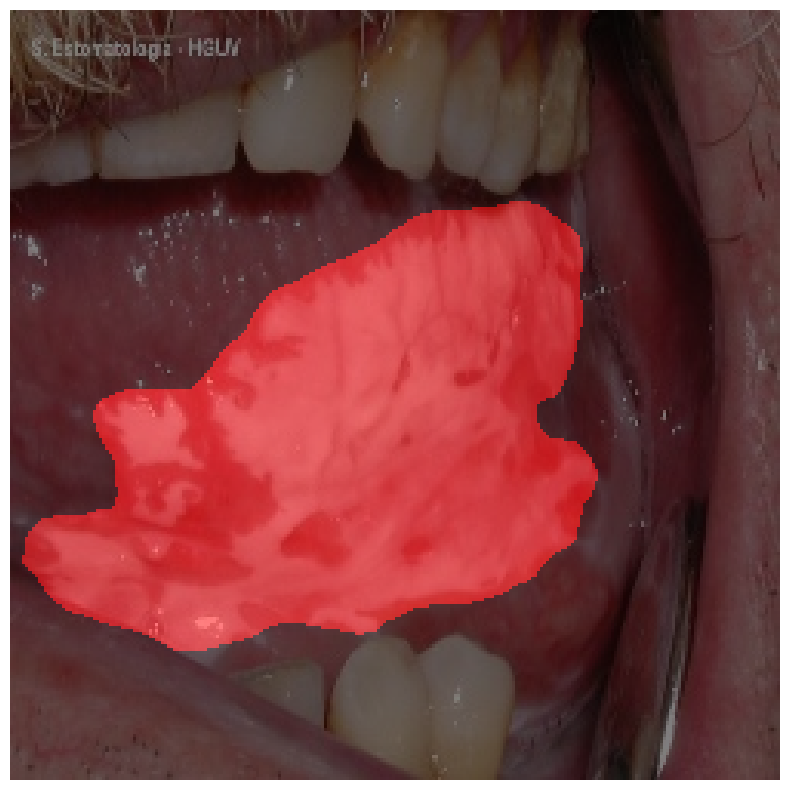

In [57]:
import numpy as np
import matplotlib.pyplot as plt

map = predicted_segmentation_map

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx in model.config.id2label else None for idx in classes_map]
print("Clases en esta imagen:", unique_classes)

color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8)  # altura, ancho, 3 canales
palette = np.array(cancer_palette())

for label, color in enumerate(palette):
    color_seg[map == label] = color


img_np = np.array(image)
blended = (img_np * 0.5 + color_seg * 0.5).astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(blended)
plt.axis('off')
plt.show()